<a href="https://colab.research.google.com/github/jwjung1994/DL-examples/blob/main/Super_Resolution_example_using_SRCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers

import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

## **Load Dataset**  
DIV2K 

In [28]:
#데이터 로드
(train, valid), info = tfds.load("div2k/bicubic_x4", split = ["train", "validation"], as_supervised=True, with_info=True)

In [29]:
# train : 800 , valid : 100
# supervised_keys=('lr', 'hr')
print(info)

tfds.core.DatasetInfo(
    name='div2k',
    version=2.0.0,
    description='DIV2K dataset: DIVerse 2K resolution high quality images as used for the challenges @ NTIRE (CVPR 2017 and CVPR 2018) and @ PIRM (ECCV 2018)',
    homepage='https://data.vision.ee.ethz.ch/cvl/DIV2K/',
    features=FeaturesDict({
        'hr': Image(shape=(None, None, 3), dtype=tf.uint8),
        'lr': Image(shape=(None, None, 3), dtype=tf.uint8),
    }),
    total_num_examples=900,
    splits={
        'train': 800,
        'validation': 100,
    },
    supervised_keys=('lr', 'hr'),
    citation="""@InProceedings{Agustsson_2017_CVPR_Workshops,
    	author = {Agustsson, Eirikur and Timofte, Radu},
    	title = {NTIRE 2017 Challenge on Single Image Super-Resolution: Dataset and Study},
    	booktitle = {The IEEE Conference on Computer Vision and Pattern Recognition (CVPR) Workshops},
        url = "http://www.vision.ee.ethz.ch/~timofter/publications/Agustsson-CVPRW-2017.pdf",
    	month = {July},
    	year = {20

In [30]:
print(train)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None))>


In [31]:
info.splits

{'train': <tfds.core.SplitInfo num_examples=800>,
 'validation': <tfds.core.SplitInfo num_examples=100>}

In [32]:
train_size = info.splits['train'].num_examples
valid_size = info.splits['validation'].num_examples
print(train_size, valid_size)

800 100


In [33]:
sample_train = next(iter(train))
random_index = np.random.choice(sample_train[0].shape[0])
random_index

48

In [34]:
def display(display_list):
    plt.figure(figsize = (20, 10))

    title = ['lr', 'hr', 'lr(zoom)', 'hr(zoom)']

    for i in range(len(title)):
        plt.subplot(2, 2, i + 1)
        plt.title(title[i], fontsize = 20)
        plt.imshow(display_list[i])

lr shape: (306, 510, 3) /// hr shape:  (1224, 2040, 3)
lr shape(after resize):  (1224, 2040, 3)


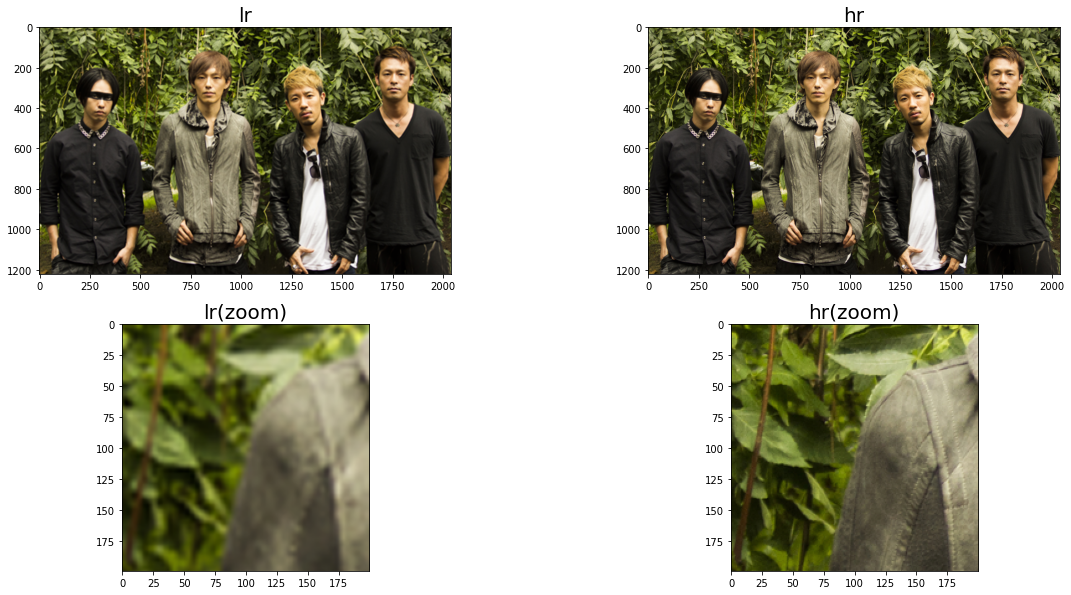

In [35]:
# 시각화
for lr, hr in train.take(1):
    hr, lr = np.array(hr),np.array(lr)
    print('lr shape:', lr.shape, '/// hr shape: ', hr.shape)

    #lr shape을 hr과 동일하게 하기 위해 보간법(bicubic interpolation) 수행
    bicubic_hr = cv2.resize(lr, dsize = (hr.shape[1], hr.shape[0]), interpolation = cv2.INTER_CUBIC)
    print('lr shape(after resize): ', bicubic_hr.shape)

    display([bicubic_hr, hr, bicubic_hr[400:600, 500:700], hr[400:600, 500:700]])

In [36]:
# 전처리
def preprocessing(lr, hr):
	# 이미지의 크기가 크므로 (96, 96, 3) 크기로 임의 영역을 잘라내어 사용합니다.
    hr = tf.image.random_crop(hr, size=[96, 96, 3])
    hr = tf.cast(hr, tf.float32) / 255.
        
    # 잘라낸 고해상도 이미지의 가로, 세로 픽셀 수를 1/4배로 줄였다가
    # interpolation을 이용해 다시 원래 크기로 되돌립니다.
    # 이렇게 만든 저해상도 이미지를 입력으로 사용합니다.
    lr = tf.image.resize(hr, [96//4, 96//4], "bicubic")
    lr = tf.image.resize(lr, [96, 96], "bicubic")
    return lr, hr

BATCH_SIZE = 16
BUFFER_SIZE = 10

train_batches = train.map(preprocessing).shuffle(buffer_size=BUFFER_SIZE).batch(BATCH_SIZE)
valid_batches = valid.map(preprocessing).batch(BATCH_SIZE)

## **Train Model**  
![Architecture](https://blackchopin.github.io/images/SRCNN/image-20210207010850462.png)

In [37]:
def conv_block(x, n_filters, size_filters):
    x = layers.Conv2D(n_filters, size_filters, padding = "same", activation = "relu")(x)
    
    return x

def build_srcnn_model():
    inputs = layers.Input(shape=(None,None,3))

    # 9 * 9 filter size
    x = conv_block(inputs, 128, 9)

    # 5 * 5 filter size
    x = conv_block(x, 64, 5)

    # 초기 입력 n_filter와 같게 해준다.
    outputs = conv_block(x, 3, 5)    

    srcnn_model = tf.keras.Model(inputs, outputs, name = "SRCNN")

    return srcnn_model

In [38]:
srcnn_model = build_srcnn_model()
srcnn_model.summary()

Model: "SRCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 conv2d_3 (Conv2D)           (None, None, None, 128)   31232     
                                                                 
 conv2d_4 (Conv2D)           (None, None, None, 64)    204864    
                                                                 
 conv2d_5 (Conv2D)           (None, None, None, 3)     4803      
                                                                 
Total params: 240,899
Trainable params: 240,899
Non-trainable params: 0
_________________________________________________________________


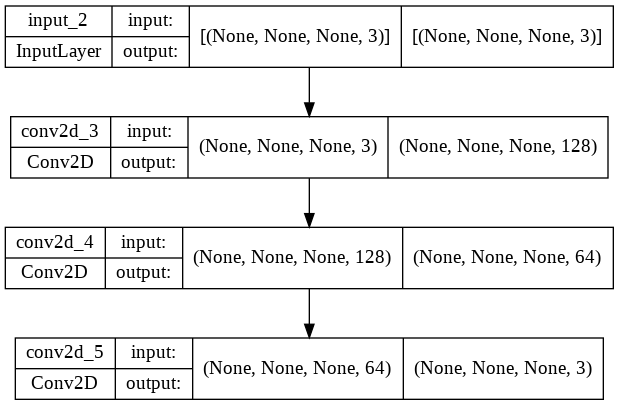

In [39]:
tf.keras.utils.plot_model(srcnn_model, show_shapes=True)

In [40]:
srcnn_model.compile(optimizer=tf.keras.optimizers.Adam(), loss="mse")

In [41]:
N_EPOCHS = 5
VAL_SUBSPLITS = 5

TRAIN_LENGTH = info.splits["train"].num_examples
VALID_LENTH = info.splits["validation"].num_examples

STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VALIDATION_STEPS = VALID_LENTH // BATCH_SIZE // VAL_SUBSPLITS

model_history = srcnn_model.fit(train_batches,
                                epochs = N_EPOCHS,
                                steps_per_epoch = STEPS_PER_EPOCH,
                                validation_steps=VALIDATION_STEPS,
                               validation_data=valid_batches)

Epoch 1/5
50/50 [==============================] - 64s 1s/step - loss: 0.0318 - val_loss: 0.0158
Epoch 2/5
50/50 [==============================] - 53s 1s/step - loss: 0.0078 - val_loss: 0.0081
Epoch 3/5
50/50 [==============================] - 53s 1s/step - loss: 0.0061 - val_loss: 0.0070
Epoch 4/5
50/50 [==============================] - 56s 1s/step - loss: 0.0051 - val_loss: 0.0028
Epoch 5/5
50/50 [==============================] - 70s 1s/step - loss: 0.0049 - val_loss: 0.0081


## **Predict**

In [56]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [59]:
import os
test_image = cv2.imread('/content/gdrive/My Drive/Colab Notebook/deep learning model practice/test_image_lr.png')

In [61]:
img = np.float32(test_image)
img

nan